In [1]:
import pandas as pd
import numpy as np
import sys
import os

import matplotlib.pyplot as plt


#Enables imports from src directory in notebooks
sys.path.insert(0, os.path.abspath('../src'))
#Auto update imports when python files in src is updated
%load_ext autoreload
%autoreload 2

In [2]:
soilqdf = pd.read_csv('E:/Universitetet i Agder/Mikkel Andreas Kvande - kornmo-data-files/raw-data/soil-data/soilquality_refined.csv')

columns_to_drop = ['Unnamed: 0', 'kartleggingsmetode', 'verifiseringsdato', 'malemetode', 'noyaktighet']
soilqdf.drop(columns_to_drop, axis=1, inplace=True)
#soilqdf = soilqdf[soilqdf['jordkvalitet'] == 2]
soilqdf.head()


,jordkvalitet,fylkeid,komid
0,1,30,3031
1,1,30,3031
2,1,30,3031
3,1,30,3031
4,1,30,3031


In [3]:
def one_hot_encode(column):
    values = list(soilqdf[column].unique())
    #print(values.index('D'))
    soilqdf[column] = soilqdf[column].apply(lambda x: values.index(x))


In [4]:
#soilqdf = soilqdf.replace(to_replace={'kartleggingsmetode': {'D': 0,'F': 1, 'J': 2, 'U': 3}})
#one_hot_encode('kartleggingsmetode')
one_hot_encode('jordkvalitet')
print(soilqdf['jordkvalitet'])


0         0
1         0
2         0
3         0
4         0
         ..
628879    1
628880    0
628881    1
628882    2
628883    1
Name: jordkvalitet, Length: 628884, dtype: int64


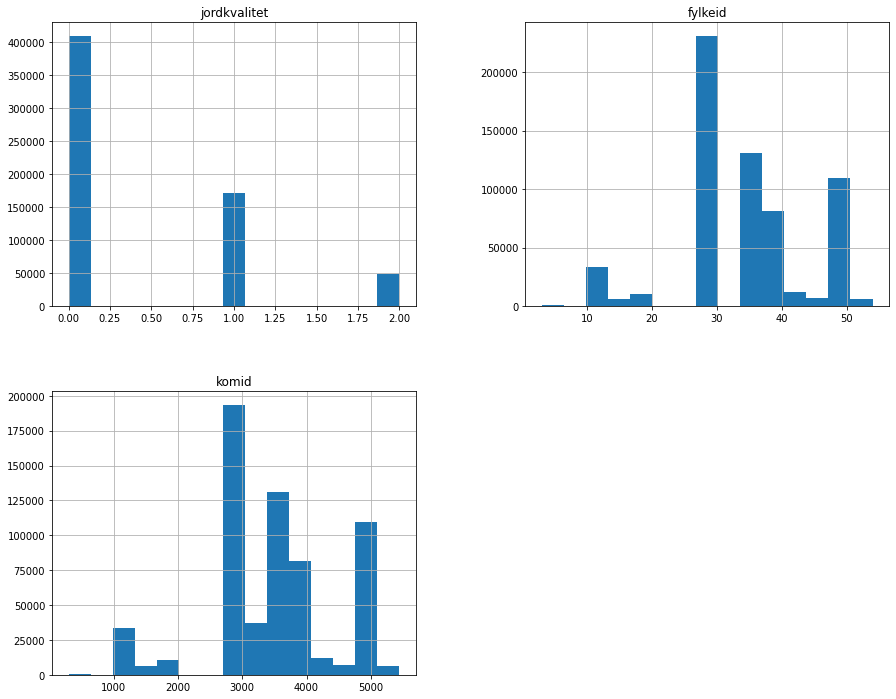

In [5]:
soilqdf.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
y = soilqdf['jordkvalitet'].astype(np.float64)
X = soilqdf.drop(columns=['jordkvalitet'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
print(y_train)


[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)

[[-0.47040569 -0.4580739 ]
 [-0.06233232 -0.03800662]
 [ 0.34574105  0.33923826]
 ...
 [ 1.56996116  1.55253936]
 [ 0.34574105  0.32802287]
 [ 0.34574105  0.32802287]]


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Normalization
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight


In [9]:
#class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#class_weights = dict(enumerate(class_weights))

In [10]:
classifier = Sequential()

classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 128, activation = 'relu'))

classifier.add(Dense(3, activation='softmax'))

classifier.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])

callback = EarlyStopping(monitor='loss', patience=3)
history = classifier.fit(X_train, y_train, batch_size=32, epochs = 100, verbose = 1, callbacks=[callback])

score, acc = classifier.evaluate(X_train, y_train, batch_size=32)
print('Train score:', score)
print('Train accuracy:', acc)



Epoch 1/100
 7232/15723 [============>.................] - ETA: 14s - loss: 0.8194 - accuracy: 0.6499

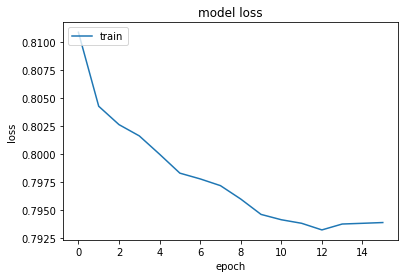

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(X_test)
y_test = [np.argmax(t) for t in y_test]
y_pred = [np.argmax(t) for t in y_pred]

cm = confusion_matrix(y_test, y_pred)


Text(0.5, 15.0, 'Predicted label')

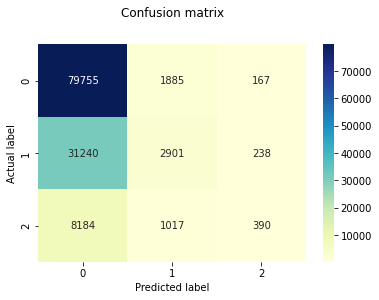

In [ ]:
import seaborn as sns

p = sns.heatmap(cm, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.97      0.79     81807
           1       0.50      0.08      0.14     34379
           2       0.49      0.04      0.08      9591

    accuracy                           0.66    125777
   macro avg       0.55      0.37      0.34    125777
weighted avg       0.61      0.66      0.56    125777

